<a href="https://colab.research.google.com/github/rajagurunath/imgCap/blob/master/HW3A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

np.random.seed(1)

# activation functions
def relu(x):
    return (x > 0) * x

def relu_deriv(x):
    return x > 0

def leaky_relu(x):
    return np.where(x > 0, x, x * 0.01)

def leaky_relu_deriv(x):
    return np.where(x > 0, 1, 0.01)

def sigmoid(x):
    sigm = 1. / (1. + np.exp(-x))
    return sigm

def sigmoid_deriv(x):
    sigm = 1. / (1. + np.exp(-x))
    return sigm * (1. - sigm)

def tanh(x):
    t = np.tanh(x)
    return t

def tanh_deriv(x):
    t = 1 - x**2
    return t

def softmax(x):
    # shift max value to 0 for improved numerical stability
    x -= np.max(x)
    temp = np.exp(x)
    return temp / np.sum(temp, axis=1, keepdims=True)

def softmax_deriv(x):
    # x * (I - x)
    # I - identity matrix, x - softmax output
    s = x.reshape(-1,1)
    return np.diagflat(s) - s.dot(s.T)

In [0]:
# utility functions

##############################################################################
# confusion matrix plot
# Taken from: scikit confusion matrix example
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.chdir("/content/drive/My Drive/")

In [0]:
# data initialization

from sklearn.preprocessing import StandardScaler

##############################################################################
# training data processing
data = pd.read_excel('HW3Atrain.xlsx')

inputs = np.concatenate((data['X_0'].to_numpy().reshape(-1, 1),\
                         data['X_1'].to_numpy().reshape(-1, 1)), axis=1)
# normalize features with zero mean and unit variance
inputs = StandardScaler().fit(inputs).transform(inputs)

y = data['y'].to_numpy().reshape(-1, 1)

labels = []
for i in range(len(y)):
    if(y[i] == 0):
        labels.append([1, 0])
    else:
        labels.append([0, 1])

labels = np.array(labels)

##############################################################################
# validation data processing
validation_data = pd.read_excel('HW3Avalidate.xlsx')

validation_inputs = np.concatenate((validation_data['X_0'].to_numpy().reshape(-1, 1),\
                                    validation_data['X_1'].to_numpy().reshape(-1, 1)), axis=1)
# normalize features data with zero mean and unit variance
validation_inputs = StandardScaler().fit(validation_inputs).transform(validation_inputs)

validation_y = validation_data['y'].to_numpy().reshape(-1, 1)

validation_labels = []
for i in range(len(validation_y)):
    if(validation_y[i] == 0):
        validation_labels.append([1, 0])
    else:
        validation_labels.append([0, 1])

validation_labels = np.array(validation_labels)

Number of epoch elapsed: 254
Early stopping criterion used: generalization_loss

Final training accuracy: 0.975609756097561
Final validation accuracy: 0.975609756097561

Confusion matrix, without normalization
[[40  1]
 [ 1 40]]



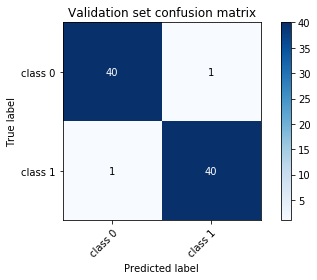

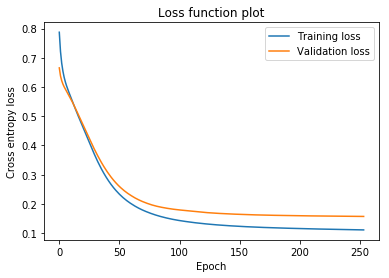

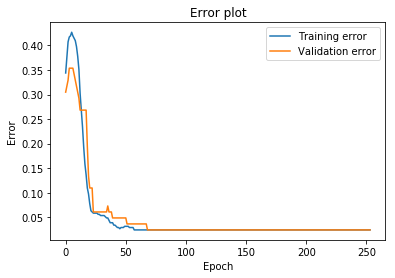

In [0]:
##############################################################################
### neural network configuration
# layer sizes
hidden_size = 10
out_size = 2

# learning rate
alpha = 0.02

# batch config
num_batches = 10
batch_size = int(inputs.shape[0] / num_batches)

##############################################################################
### early stopping (ES) config
# criterion : check criterion every N epoch
ES_config = {
    'validation_loss' : 5,
    'generalization_loss': 2
}

# stopping criteria
# Based on: "Early Stopping | but when?" Lutz Prechelt
# https://page.mi.fu-berlin.de/prechelt/Biblio/stop_tricks1997.pdf
# - validation loss - stop immediately when val. loss start increasing
# - generalization loss - stop when gen. loss exceeds threshold
#   rule: ((val_loss[-1] / min(val_loss[:])) - 1) > thold
# - progress - stop when validation loss value change falls below threshold

#ES_criterion = 'validation_loss'
ES_criterion = 'generalization_loss'

# stop when generalization loss exceeds threshold
gen_loss_thold = 0.01

# stop when validation loss progress is below threshold
validation_progress_thold = 0.1

# check stopping criterion every N epoch
ES_N_epoch = ES_config[ES_criterion]

# prevent training from stopping too early when loss might
# still be changing rapidly
min_epochs = 100

# max training time
max_epochs = 3000

##############################################################################
# weight initialization

# He initialization
# https://www.cv-foundation.org/openaccess/content_iccv_2015/papers/He_Delving_Deep_into_ICCV_2015_paper.pdf
h1_weights = np.random.randn(inputs.shape[1], hidden_size) * np.sqrt(2 / (inputs.shape[1]))
h2_weights = np.random.randn(hidden_size, hidden_size) * np.sqrt(2 / (hidden_size))

# Xavier initialization
# http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf
out_weights = np.random.uniform(-1,1,size=(hidden_size, out_size)) * np.sqrt(6) / np.sqrt(hidden_size + out_size)

##############################################################################
# bias initialization
h1_bias = np.zeros((1, hidden_size))
h2_bias = np.zeros((1, hidden_size))
out_bias = np.zeros((1, out_size))

##############################################################################
# NN performance statistics
training_error = []
validation_error = []

training_loss = []
validation_loss = []

pred = np.zeros(inputs.shape)

##############################################################################
# neural network training
epoch = 0  

while(epoch < max_epochs):
    epoch += 1
    correct_cnt = 0
    
    for batch in range(num_batches):
        batch_start = batch * batch_size
        batch_end = (batch + 1) * batch_size
        
        # feedforward
        h1_out = leaky_relu(inputs[batch_start:batch_end].dot(h1_weights) + h1_bias)
        h2_out = leaky_relu(h1_out.dot(h2_weights) + h2_bias)
        out = softmax(h2_out.dot(out_weights) + out_bias)

        # save outputs
        for i in range(batch_size):
            correct_cnt += int(np.argmax(out[i]) == \
                               np.argmax(labels[batch_start+i]))
        pred[batch_start:batch_end] = out

        # backpropagation
        out_delta = (out - labels[batch_start:batch_end]) / (out.shape[0] * out.shape[1])
        h2_delta = out_delta.dot(out_weights.T) * leaky_relu_deriv(h2_out)
        h1_delta = h2_delta.dot(h2_weights.T) * leaky_relu_deriv(h1_out)

        out_weights -= alpha * h2_out.T.dot(out_delta)
        h2_weights -= alpha * h1_out.T.dot(h2_delta)
        h1_weights -= alpha * inputs[batch_start:batch_end].T.dot(h1_delta)
        
        out_bias -= alpha * np.sum(out_delta, axis=0, keepdims=True)
        h2_bias -= alpha * np.sum(h2_delta, axis=0, keepdims=True)
        h1_bias -= alpha * np.sum(h1_delta, axis=0, keepdims=True)
    
    # training loss and error
    training_error.append(1 - correct_cnt/len(inputs))
    training_loss.append(log_loss(labels, pred))
    
    # validation loss and error
    validation_correct_cnt = 0
    h1_out = relu(validation_inputs.dot(h1_weights))
    h2_out = relu(h1_out.dot(h2_weights))
    out = softmax(h2_out.dot(out_weights))
    
    for i in range(len(validation_inputs)):
        validation_correct_cnt += int(np.argmax(out[i]) == \
                                      np.argmax(validation_labels[i]))
    validation_pred = out
    
    validation_error.append(1 - validation_correct_cnt/len(validation_inputs))
    validation_loss.append(log_loss(validation_labels, validation_pred))
    
    # check early stopping conditions every N epoch
    if(epoch % ES_N_epoch == 0):
        if((ES_criterion == 'validation_loss')\
           and (validation_loss[-1] > validation_loss[-ES_N_epoch])\
           and (epoch > min_epochs)):
            # stop training
            break
        elif((ES_criterion == 'generalization_loss')\
             and ((validation_loss[-1]/min(validation_loss) - 1) > gen_loss_thold)\
             and (epoch > min_epochs)):
            # stop training
            break

        # progress describes how quickly validation loss changes 
        progress = 1000 * (np.sum(validation_loss[-1:-(ES_N_epoch+1):-1])\
                           / (ES_N_epoch * min(validation_loss[-1:-(ES_N_epoch+1):-1])) - 1)            
        if(progress < validation_progress_thold):
            # stop training
            break

##############################################################################
# training summary
print("Number of epoch elapsed:", epoch)
print("Early stopping criterion used:", ES_criterion)
print("")

# pick accuracy from the last successful early stopping check
print("Final training accuracy:", 1 - training_error[-ES_N_epoch])
print("Final validation accuracy:", 1 - validation_error[-ES_N_epoch])
print("")

#confusion_matrix(validation_y, np.argmax(validation_pred, axis=1), labels=[0, 1])
np.set_printoptions(precision=2)
plot_confusion_matrix(validation_y, np.argmax(validation_pred, axis=1), np.array(["class 0", "class 1"]),\
                      title="Validation set confusion matrix")
print("")

# loss funtion plot
fig, ax = plt.subplots()
training_loss_line, = ax.plot(range(epoch), training_loss)
validation_loss_line, = ax.plot(range(epoch), validation_loss)
ax.set(xlabel="Epoch", ylabel="Cross entropy loss", title="Loss function plot")
plt.legend((training_loss_line, validation_loss_line), ('Training loss', 'Validation loss'))

# error funtion plot
fig, ax = plt.subplots()
training_error_line, = ax.plot(range(epoch), training_error)
validation_error_line, = ax.plot(range(epoch), validation_error)
ax.set(xlabel="Epoch", ylabel="Error", title="Error plot")
plt.legend((training_error_line, validation_error_line), ('Training error', 'Validation error'))

# HW3B

 ## (10 points) Parameter initialization
 Choose the best performing model from HW3A in terms
of classification accuracy. For this model, initialize all its parameters (connection weights and biases) to zero and retrain it using all the other settings from HW3A. Report the performance (e.g.loss function over training epochs, classification accuracy and confusion matrix on the validation
set after training) of this new trained model. Do you observe any interesting behavior for this new trained model? Discuss the performance of this new trained model in comparison with the performance of the best model from HW3A.

Number of epoch elapsed: 2
Early stopping criterion used: generalization_loss

Final training accuracy: 0.47804878048780486
Final validation accuracy: 0.5

Confusion matrix, without normalization
[[41  0]
 [41  0]]



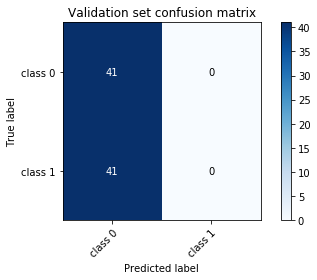

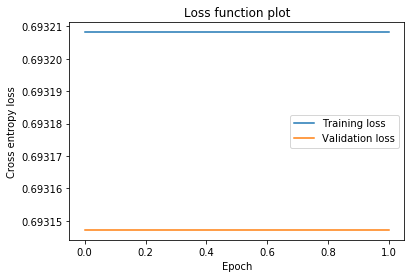

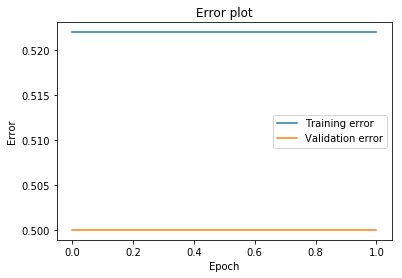

In [0]:
#zero init
def hw3a_1():
  h1_weights = np.zeros((inputs.shape[1], hidden_size)) * np.sqrt(2 / (inputs.shape[1]))
  h2_weights = np.zeros((hidden_size, hidden_size)) * np.sqrt(2 / (hidden_size))

  # Xavier initialization
  # http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf
  #out_weights = np.random.uniform(-1,1,size=(hidden_size, out_size)) * np.sqrt(6) / np.sqrt(hidden_size + out_size)
  out_weights = np.zeros((hidden_size, out_size))
  ##############################################################################
  # bias initialization
  h1_bias = np.zeros((1, hidden_size))
  h2_bias = np.zeros((1, hidden_size))
  out_bias = np.zeros((1, out_size))

  ##############################################################################
  # NN performance statistics
  training_error = []
  validation_error = []

  training_loss = []
  validation_loss = []

  pred = np.zeros(inputs.shape)

  ##############################################################################
  # neural network training
  epoch = 0  

  while(epoch < max_epochs):
      epoch += 1
      correct_cnt = 0
      
      for batch in range(num_batches):
          batch_start = batch * batch_size
          batch_end = (batch + 1) * batch_size
          
          # feedforward
          h1_out = leaky_relu(inputs[batch_start:batch_end].dot(h1_weights) + h1_bias)
          h2_out = leaky_relu(h1_out.dot(h2_weights) + h2_bias)
          out = softmax(h2_out.dot(out_weights) + out_bias)

          # save outputs
          for i in range(batch_size):
              correct_cnt += int(np.argmax(out[i]) == \
                                np.argmax(labels[batch_start+i]))
          pred[batch_start:batch_end] = out

          # backpropagation
          out_delta = (out - labels[batch_start:batch_end]) / (out.shape[0] * out.shape[1])
          h2_delta = out_delta.dot(out_weights.T) * leaky_relu_deriv(h2_out)
          h1_delta = h2_delta.dot(h2_weights.T) * leaky_relu_deriv(h1_out)

          out_weights -= alpha * h2_out.T.dot(out_delta)
          h2_weights -= alpha * h1_out.T.dot(h2_delta)
          h1_weights -= alpha * inputs[batch_start:batch_end].T.dot(h1_delta)
          
          out_bias -= alpha * np.sum(out_delta, axis=0, keepdims=True)
          h2_bias -= alpha * np.sum(h2_delta, axis=0, keepdims=True)
          h1_bias -= alpha * np.sum(h1_delta, axis=0, keepdims=True)
      
      # training loss and error
      training_error.append(1 - correct_cnt/len(inputs))
      training_loss.append(log_loss(labels, pred))
      
      # validation loss and error
      validation_correct_cnt = 0
      h1_out = relu(validation_inputs.dot(h1_weights))
      h2_out = relu(h1_out.dot(h2_weights))
      out = softmax(h2_out.dot(out_weights))
      
      for i in range(len(validation_inputs)):
          validation_correct_cnt += int(np.argmax(out[i]) == \
                                        np.argmax(validation_labels[i]))
      validation_pred = out
      
      validation_error.append(1 - validation_correct_cnt/len(validation_inputs))
      validation_loss.append(log_loss(validation_labels, validation_pred))
      
      # check early stopping conditions every N epoch
      if(epoch % ES_N_epoch == 0):
          if((ES_criterion == 'validation_loss')\
            and (validation_loss[-1] > validation_loss[-ES_N_epoch])\
            and (epoch > min_epochs)):
              # stop training
              break
          elif((ES_criterion == 'generalization_loss')\
              and ((validation_loss[-1]/min(validation_loss) - 1) > gen_loss_thold)\
              and (epoch > min_epochs)):
              # stop training
              break

          # progress describes how quickly validation loss changes 
          progress = 1000 * (np.sum(validation_loss[-1:-(ES_N_epoch+1):-1])\
                            / (ES_N_epoch * min(validation_loss[-1:-(ES_N_epoch+1):-1])) - 1)            
          if(progress < validation_progress_thold):
              # stop training
              break

  ##############################################################################
  # training summary
  print("Number of epoch elapsed:", epoch)
  print("Early stopping criterion used:", ES_criterion)
  print("")

  # pick accuracy from the last successful early stopping check
  print("Final training accuracy:", 1 - training_error[-ES_N_epoch])
  print("Final validation accuracy:", 1 - validation_error[-ES_N_epoch])
  print("")

  #confusion_matrix(validation_y, np.argmax(validation_pred, axis=1), labels=[0, 1])
  np.set_printoptions(precision=2)
  plot_confusion_matrix(validation_y, np.argmax(validation_pred, axis=1), np.array(["class 0", "class 1"]),\
                        title="Validation set confusion matrix")
  print("")

  # loss funtion plot
  fig, ax = plt.subplots()
  training_loss_line, = ax.plot(range(epoch), training_loss)
  validation_loss_line, = ax.plot(range(epoch), validation_loss)
  ax.set(xlabel="Epoch", ylabel="Cross entropy loss", title="Loss function plot")
  plt.legend((training_loss_line, validation_loss_line), ('Training loss', 'Validation loss'))

  # error funtion plot
  fig, ax = plt.subplots()
  training_error_line, = ax.plot(range(epoch), training_error)
  validation_error_line, = ax.plot(range(epoch), validation_error)
  ax.set(xlabel="Epoch", ylabel="Error", title="Error plot")
  plt.legend((training_error_line, validation_error_line), ('Training error', 'Validation error'))

hw3a_1()

## Learning rate vs parameter initialization. 
Retrain several times for the same fixed amount of epochs (e.g. 100 - this value is your choice) the best model from HW3A using exactly
the same settings as in HW3A, with the exception of the learning rate and the initialization of
the connection weights and biases which have to be different for each retraining. Start with a
very small learning rate (e.g. 0.0001) and after that gradually increase it (e.g. next values can be
.001, 0.01, ...). Initialize the connection weights and biases by sampling from a normal distribution
N (0, σ2
). σ
2 has to take the following values {0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1}. Make a
heatmap2 where the x-axis represents σ
2
, the y −axis represents the learning rate, while the colors
represent the accuracy3 obtained on the validation set after each training. Each element in the
heatmap matrix represents practically the accuracy obtained with a specific learning rate and a
specific initialization. Discuss the heatmap results.

In [0]:
def trainModel(alpha,h1_weights, h2_weights, out_weights, h1_bias, h2_bias, out_bias,verbose=True):
  ##############################################################################
  # NN performance statistics
  training_error = []
  validation_error = []

  training_loss = []
  validation_loss = []

  pred = np.zeros(inputs.shape)

  ##############################################################################
  # neural network training
  epoch = 0  

  while(epoch < max_epochs):
      epoch += 1
      correct_cnt = 0
      
      for batch in range(num_batches):
          batch_start = batch * batch_size
          batch_end = (batch + 1) * batch_size
          
          # feedforward
          h1_out = leaky_relu(inputs[batch_start:batch_end].dot(h1_weights) + h1_bias)
          h2_out = leaky_relu(h1_out.dot(h2_weights) + h2_bias)
          out = softmax(h2_out.dot(out_weights) + out_bias)

          # save outputs
          for i in range(batch_size):
              correct_cnt += int(np.argmax(out[i]) == \
                                np.argmax(labels[batch_start+i]))
          pred[batch_start:batch_end] = out

          # backpropagation
          out_delta = (out - labels[batch_start:batch_end]) / (out.shape[0] * out.shape[1])
          h2_delta = out_delta.dot(out_weights.T) * leaky_relu_deriv(h2_out)
          h1_delta = h2_delta.dot(h2_weights.T) * leaky_relu_deriv(h1_out)

          out_weights -= alpha * h2_out.T.dot(out_delta)
          h2_weights -= alpha * h1_out.T.dot(h2_delta)
          h1_weights -= alpha * inputs[batch_start:batch_end].T.dot(h1_delta)
          
          out_bias -= alpha * np.sum(out_delta, axis=0, keepdims=True)
          h2_bias -= alpha * np.sum(h2_delta, axis=0, keepdims=True)
          h1_bias -= alpha * np.sum(h1_delta, axis=0, keepdims=True)
      
      # training loss and error
      training_error.append(1 - correct_cnt/len(inputs))
      training_loss.append(log_loss(labels, pred))
      
      # validation loss and error
      validation_correct_cnt = 0
      h1_out = relu(validation_inputs.dot(h1_weights))
      h2_out = relu(h1_out.dot(h2_weights))
      out = softmax(h2_out.dot(out_weights))
      
      for i in range(len(validation_inputs)):
          validation_correct_cnt += int(np.argmax(out[i]) == \
                                        np.argmax(validation_labels[i]))
      validation_pred = out
      
      validation_error.append(1 - validation_correct_cnt/len(validation_inputs))
      validation_loss.append(log_loss(validation_labels, validation_pred))
      
      # check early stopping conditions every N epoch
      if(epoch % ES_N_epoch == 0):
          if((ES_criterion == 'validation_loss')\
            and (validation_loss[-1] > validation_loss[-ES_N_epoch])\
            and (epoch > min_epochs)):
              # stop training
              break
          elif((ES_criterion == 'generalization_loss')\
              and ((validation_loss[-1]/min(validation_loss) - 1) > gen_loss_thold)\
              and (epoch > min_epochs)):
              # stop training
              break

          # progress describes how quickly validation loss changes 
          progress = 1000 * (np.sum(validation_loss[-1:-(ES_N_epoch+1):-1])\
                            / (ES_N_epoch * min(validation_loss[-1:-(ES_N_epoch+1):-1])) - 1)            
          if(progress < validation_progress_thold):
              # stop training
              break
  if verbose:
    ##############################################################################
    # training summary
    print("Number of epoch elapsed:", epoch)
    print("Early stopping criterion used:", ES_criterion)
    print("")

    # pick accuracy from the last successful early stopping check
    print("Final training accuracy:", 1 - training_error[-ES_N_epoch])
    print("Final validation accuracy:", 1 - validation_error[-ES_N_epoch])
    print("")

    #confusion_matrix(validation_y, np.argmax(validation_pred, axis=1), labels=[0, 1])
    np.set_printoptions(precision=2)
    plot_confusion_matrix(validation_y, np.argmax(validation_pred, axis=1), np.array(["class 0", "class 1"]),\
                          title="Validation set confusion matrix")
    print("")

    # loss funtion plot
    fig, ax = plt.subplots()
    training_loss_line, = ax.plot(range(epoch), training_loss)
    validation_loss_line, = ax.plot(range(epoch), validation_loss)
    ax.set(xlabel="Epoch", ylabel="Cross entropy loss", title="Loss function plot")
    plt.legend((training_loss_line, validation_loss_line), ('Training loss', 'Validation loss'))

    # error funtion plot
    fig, ax = plt.subplots()
    training_error_line, = ax.plot(range(epoch), training_error)
    validation_error_line, = ax.plot(range(epoch), validation_error)
    ax.set(xlabel="Epoch", ylabel="Error", title="Error plot")
    plt.legend((training_error_line, validation_error_line), ('Training error', 'Validation error'))
    plt.show()
  return 1 - validation_error[-ES_N_epoch]

Number of epoch elapsed: 208
Early stopping criterion used: generalization_loss

Final training accuracy: 0.975609756097561
Final validation accuracy: 0.9634146341463414

Confusion matrix, without normalization
[[40  1]
 [ 2 39]]



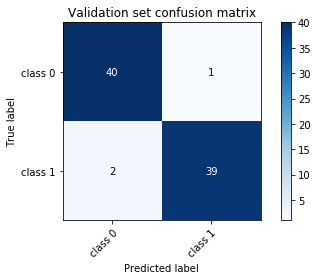

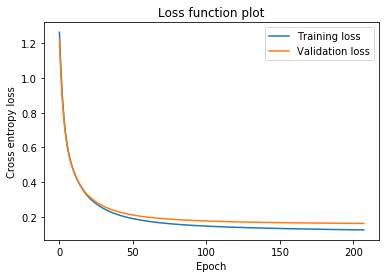

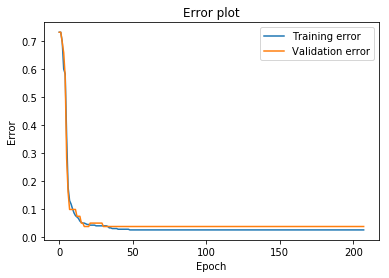

In [0]:
h1_weights = np.random.randn(inputs.shape[1], hidden_size) * np.sqrt(2 / (inputs.shape[1]))
h2_weights = np.random.randn(hidden_size, hidden_size) * np.sqrt(2 / (hidden_size))

# Xavier initialization
# http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf
out_weights = np.random.uniform(-1,1,size=(hidden_size, out_size)) * np.sqrt(6) / np.sqrt(hidden_size + out_size)

##############################################################################
# bias initialization
h1_bias = np.zeros((1, hidden_size))
h2_bias = np.zeros((1, hidden_size))
out_bias = np.zeros((1, out_size))

trainModel(alpha,h1_weights, h2_weights, out_weights, h1_bias, h2_bias, out_bias)

In [0]:
def create_weights_and_biases(variance):
    hidden_size = 10
    out_size = 2
    
    mean = 0.5
    
    h1_b = np.random.normal(mean, np.sqrt(variance), size=(1, hidden_size))
    h2_b = np.random.normal(mean, np.sqrt(variance), size=(1, hidden_size))
    out_b = np.random.normal(mean, np.sqrt(variance), size=(1, out_size))
    
    # He initialization
    # https://www.cv-foundation.org/openaccess/content_iccv_2015/papers/He_Delving_Deep_into_ICCV_2015_paper.pdf
    h1_w = np.random.normal(mean, np.sqrt(variance), size=(inputs.shape[1], hidden_size)) * np.sqrt(2 / (inputs.shape[1]))
    h2_w = np.random.normal(mean, np.sqrt(variance), size=(hidden_size, hidden_size)) * np.sqrt(2 / (hidden_size))

    # Xavier initialization
    # http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf
    out_w = np.random.normal(mean, np.sqrt(variance), size=(hidden_size, out_size)) * np.sqrt(6) / np.sqrt(hidden_size + out_size)
    
    return (h1_w, h2_w, out_w, h1_b, h2_b, out_b)

In [0]:
def hw3a_2(learning_rate_list,variance_list):
  """
  trains a model using different learning rate and with different initilization and 
  returns Accuracy for each for each iteration
  """
  alpha_list=[]
  var_list=[]
  val_acc_list=[]
  for alpha in learning_rate_list:
    for var in variance_list:
      h1_weights, h2_weights, out_weights, h1_bias, h2_bias, out_bias=create_weights_and_biases(var)
      acc=trainModel(alpha,h1_weights, h2_weights, out_weights, h1_bias, h2_bias, out_bias,verbose=False)
      print(var,alpha,acc)
      alpha_list.append(alpha)
      var_list.append(var)
      val_acc_list.append(acc)

  res=pd.DataFrame()
  res['learning_rate']=alpha_list
  res['variance']=var_list
  res['acc']=val_acc_list
  
  return res


0 0.0001 0.5
0.1 0.0001 0.5487804878048781
0.2 0.0001 0.5
0.3 0.0001 0.5975609756097561
0.4 0.0001 0.4024390243902439
0.5 0.0001 0.8536585365853658
0.6 0.0001 0.5
0.7 0.0001 0.5853658536585366
0.8 0.0001 0.47560975609756095
0.9 0.0001 0.5
1.0 0.0001 0.46341463414634143
0 0.00025 0.5
0.1 0.00025 0.6219512195121951
0.2 0.00025 0.7195121951219512
0.3 0.00025 0.7317073170731707
0.4 0.00025 0.8536585365853658
0.5 0.00025 0.5
0.6 0.00025 0.6219512195121951
0.7 0.00025 0.46341463414634143
0.8 0.00025 0.9146341463414634
0.9 0.00025 0.8170731707317073
1.0 0.00025 0.573170731707317
0 0.0005 0.5
0.1 0.0005 0.30487804878048785
0.2 0.0005 0.6463414634146342
0.3 0.0005 0.5
0.4 0.0005 0.9634146341463414
0.5 0.0005 0.6219512195121951
0.6 0.0005 0.524390243902439
0.7 0.0005 0.7195121951219512
0.8 0.0005 0.47560975609756095
0.9 0.0005 0.36585365853658536
1.0 0.0005 0.8414634146341463
0 0.00075 0.5
0.1 0.00075 0.5
0.2 0.00075 0.3170731707317074
0.3 0.00075 0.6585365853658537
0.4 0.00075 0.5
0.5 0.00075 0

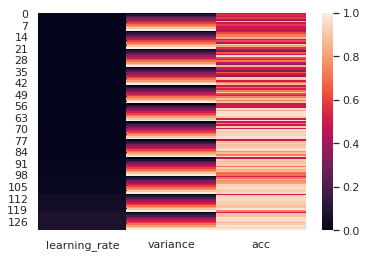

In [0]:
learning_rates = [0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005, 0.0075, 0.01, 0.02, 0.05, 0.075]
variances = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

res=hw3a_2(learning_rates,variances)
#sns.heatmap(res)

+-----------------+-------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
|   learning_rate |   0.0 |      0.1 |      0.2 |      0.3 |      0.4 |      0.5 |      0.6 |      0.7 |      0.8 |      0.9 |      1.0 |
|-----------------+-------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------|
|         0.0001  |   0.5 | 0.54878  | 0.5      | 0.597561 | 0.402439 | 0.853659 | 0.5      | 0.585366 | 0.47561  | 0.5      | 0.463415 |
|         0.00025 |   0.5 | 0.621951 | 0.719512 | 0.731707 | 0.853659 | 0.5      | 0.621951 | 0.463415 | 0.914634 | 0.817073 | 0.573171 |
|         0.0005  |   0.5 | 0.304878 | 0.646341 | 0.5      | 0.963415 | 0.621951 | 0.52439  | 0.719512 | 0.47561  | 0.365854 | 0.841463 |
|         0.00075 |   0.5 | 0.5      | 0.317073 | 0.658537 | 0.5      | 0.390244 | 0.926829 | 0.902439 | 0.5      | 0.719512 | 0.878049 |
|         0.001   |   0.5 | 0.6707

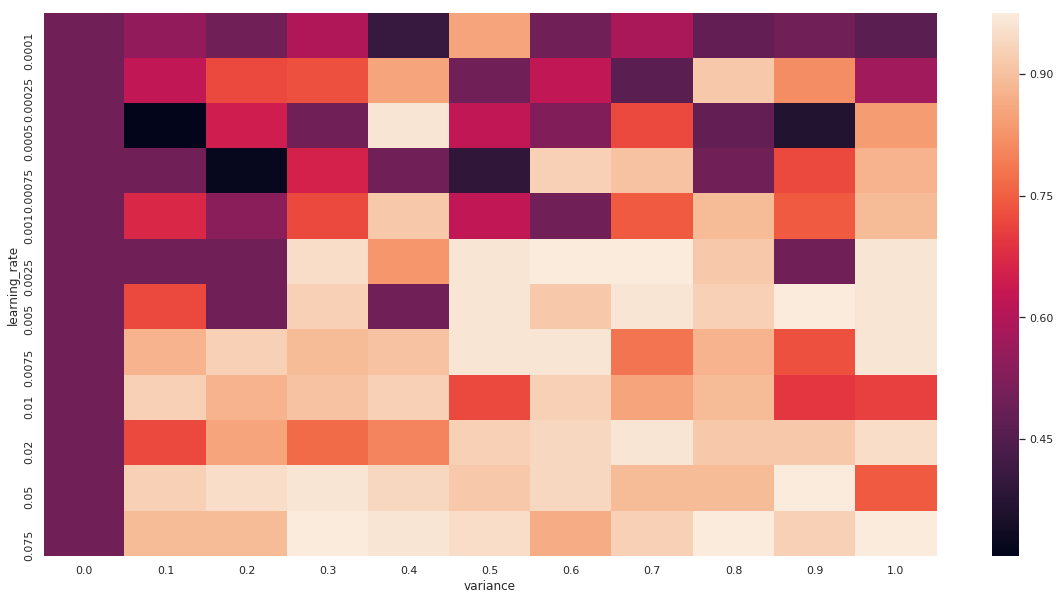

In [0]:
_map=res.pivot('learning_rate', 'variance', 'acc')
import tabulate
print(tabulate.tabulate(_map,headers='keys', tablefmt='psql'))
fig, ax = plt.subplots(figsize=(20,10))

sns.heatmap(_map,ax=ax)

In [0]:
_map

variance,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
learning_rate,,,,,,,,,,,
0.00010,0.5,0.548780,0.500000,0.597561,0.402439,0.853659,0.500000,0.585366,0.475610,0.500000,0.463415
0.00025,0.5,0.621951,0.719512,0.731707,0.853659,0.500000,0.621951,0.463415,0.914634,0.817073,0.573171
0.00050,0.5,0.304878,0.646341,0.500000,0.963415,0.621951,0.524390,0.719512,0.475610,0.365854,0.841463
0.00075,0.5,0.500000,0.317073,0.658537,0.500000,0.390244,0.926829,0.902439,0.500000,0.719512,0.878049
0.00100,0.5,0.670732,0.536585,0.719512,0.914634,0.621951,0.500000,0.743902,0.890244,0.743902,0.890244
0.00250,0.5,0.500000,0.500000,0.951220,0.829268,0.963415,0.975610,0.975610,0.914634,0.500000,0.963415
0.00500,0.5,0.719512,0.500000,0.926829,0.500000,0.963415,0.914634,0.963415,0.926829,0.975610,0.963415
0.00750,0.5,0.878049,0.926829,0.890244,0.902439,0.963415,0.963415,0.780488,0.878049,0.731707,0.963415
0.01000,0.5,0.926829,0.878049,0.902439,0.926829,0.719512,0.926829,0.853659,0.890244,0.695122,0.707317


In [0]:

_map.max(axis=1).argmax(),_map.max().argmax()
_map.max(axis=1),_map.max(),_map.max(axis=1).argmax(),_map.max().argmax()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


(learning_rate
 0.00010    0.853659
 0.00025    0.914634
 0.00050    0.963415
 0.00075    0.926829
 0.00100    0.914634
 0.00250    0.975610
 0.00500    0.975610
 0.00750    0.963415
 0.01000    0.926829
 0.02000    0.963415
 0.05000    0.975610
 0.07500    0.975610
 dtype: float64, variance
 0.0    0.500000
 0.1    0.926829
 0.2    0.951220
 0.3    0.975610
 0.4    0.963415
 0.5    0.963415
 0.6    0.975610
 0.7    0.975610
 0.8    0.975610
 0.9    0.975610
 1.0    0.975610
 dtype: float64, 0.0025, 0.3)

In [0]:
_map.min(axis=1).argmin(),_map.min().argmin()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  """Entry point for launching an IPython kernel.


(0.0005, 0.1, 0.0025, 0.3)

## Lowest value of Accuracy-0.304878 occured at (0.00050,0.1)
## Highest value of acc -0.975610 (occurs multiple times lets take one)-
(0.075,1)

In [0]:
def plotActivation(h1_out,h2_out):
  fig,ax=plt.subplots(1,2,figsize=(20,10))
  sns.heatmap(h1_out,ax=ax[0])
  sns.heatmap(h2_out,ax=ax[1]) 
  plt.show()

In [0]:
def showActivation(alpha,h1_weights, h2_weights, out_weights, h1_bias, h2_bias, out_bias,verbose=True):
  ##############################################################################
  # NN performance statistics
  training_error = []
  validation_error = []

  training_loss = []
  validation_loss = []

  pred = np.zeros(inputs.shape)

  ##############################################################################
  # neural network training
  epoch = 0  
  h1_out = relu(validation_inputs.dot(h1_weights))
  h2_out = relu(h1_out.dot(h2_weights))
  plotActivation(h1_out,h2_out)
  while(epoch < max_epochs):
      epoch += 1
      correct_cnt = 0
      
      for batch in range(num_batches):
          batch_start = batch * batch_size
          batch_end = (batch + 1) * batch_size
          
          # feedforward
          h1_out = leaky_relu(inputs[batch_start:batch_end].dot(h1_weights) + h1_bias)
          h2_out = leaky_relu(h1_out.dot(h2_weights) + h2_bias)
          out = softmax(h2_out.dot(out_weights) + out_bias)
          

          # save outputs
          for i in range(batch_size):
              correct_cnt += int(np.argmax(out[i]) == \
                                np.argmax(labels[batch_start+i]))
          pred[batch_start:batch_end] = out

          # backpropagation
          out_delta = (out - labels[batch_start:batch_end]) / (out.shape[0] * out.shape[1])
          h2_delta = out_delta.dot(out_weights.T) * leaky_relu_deriv(h2_out)
          h1_delta = h2_delta.dot(h2_weights.T) * leaky_relu_deriv(h1_out)

          out_weights -= alpha * h2_out.T.dot(out_delta)
          h2_weights -= alpha * h1_out.T.dot(h2_delta)
          h1_weights -= alpha * inputs[batch_start:batch_end].T.dot(h1_delta)
          
          out_bias -= alpha * np.sum(out_delta, axis=0, keepdims=True)
          h2_bias -= alpha * np.sum(h2_delta, axis=0, keepdims=True)
          h1_bias -= alpha * np.sum(h1_delta, axis=0, keepdims=True)
      
      # training loss and error
      training_error.append(1 - correct_cnt/len(inputs))
      training_loss.append(log_loss(labels, pred))
      
      # validation loss and error
      validation_correct_cnt = 0
      h1_out = relu(validation_inputs.dot(h1_weights))
      h2_out = relu(h1_out.dot(h2_weights))
      out = softmax(h2_out.dot(out_weights))
      if epoch==50:
        plotActivation(h1_out,h2_out)
      for i in range(len(validation_inputs)):
          validation_correct_cnt += int(np.argmax(out[i]) == \
                                        np.argmax(validation_labels[i]))
      validation_pred = out
      
      validation_error.append(1 - validation_correct_cnt/len(validation_inputs))
      validation_loss.append(log_loss(validation_labels, validation_pred))
      
      # check early stopping conditions every N epoch
      if(epoch % ES_N_epoch == 0):
          if((ES_criterion == 'validation_loss')\
            and (validation_loss[-1] > validation_loss[-ES_N_epoch])\
            and (epoch > min_epochs)):
              # stop training
              break
          elif((ES_criterion == 'generalization_loss')\
              and ((validation_loss[-1]/min(validation_loss) - 1) > gen_loss_thold)\
              and (epoch > min_epochs)):
              # stop training
              break

          # progress describes how quickly validation loss changes 
          progress = 1000 * (np.sum(validation_loss[-1:-(ES_N_epoch+1):-1])\
                            / (ES_N_epoch * min(validation_loss[-1:-(ES_N_epoch+1):-1])) - 1)            
          if(progress < validation_progress_thold):
              # stop training
              break
  plotActivation(h1_out,h2_out)
  if verbose:
    ##############################################################################
    # training summary
    print("Number of epoch elapsed:", epoch)
    print("Early stopping criterion used:", ES_criterion)
    print("")

    # pick accuracy from the last successful early stopping check
    print("Final training accuracy:", 1 - training_error[-ES_N_epoch])
    print("Final validation accuracy:", 1 - validation_error[-ES_N_epoch])
    print("")

    #confusion_matrix(validation_y, np.argmax(validation_pred, axis=1), labels=[0, 1])
    np.set_printoptions(precision=2)
    plot_confusion_matrix(validation_y, np.argmax(validation_pred, axis=1), np.array(["class 0", "class 1"]),\
                          title="Validation set confusion matrix")
    print("")

    # loss funtion plot
    fig, ax = plt.subplots()
    training_loss_line, = ax.plot(range(epoch), training_loss)
    validation_loss_line, = ax.plot(range(epoch), validation_loss)
    ax.set(xlabel="Epoch", ylabel="Cross entropy loss", title="Loss function plot")
    plt.legend((training_loss_line, validation_loss_line), ('Training loss', 'Validation loss'))

    # error funtion plot
    fig, ax = plt.subplots()
    training_error_line, = ax.plot(range(epoch), training_error)
    validation_error_line, = ax.plot(range(epoch), validation_error)
    ax.set(xlabel="Epoch", ylabel="Error", title="Error plot")
    plt.legend((training_error_line, validation_error_line), ('Training error', 'Validation error'))
    plt.show()
  return 1 - validation_error[-ES_N_epoch]

## worst model


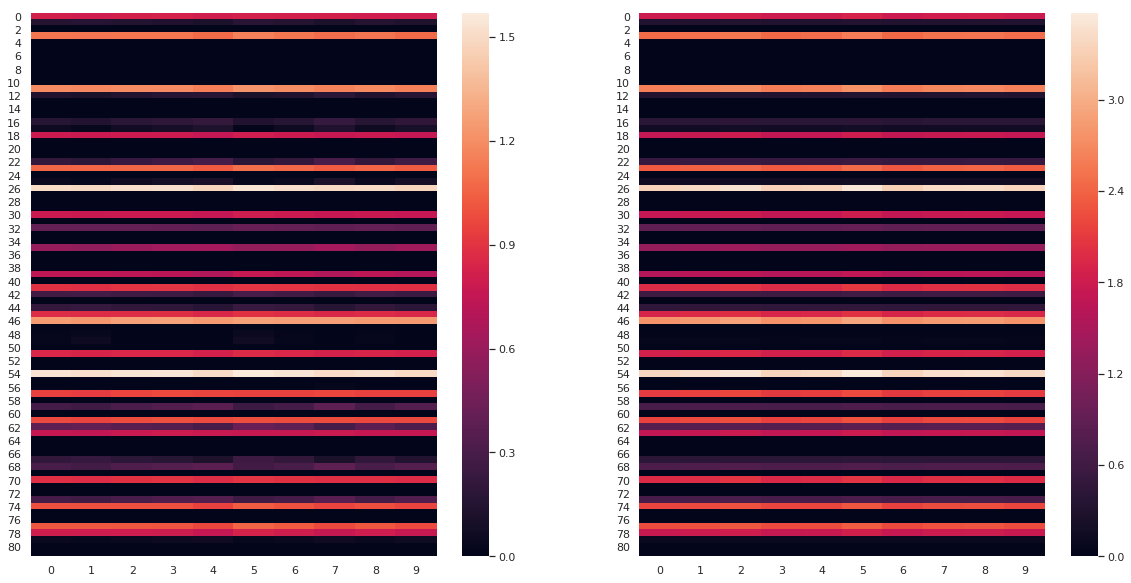

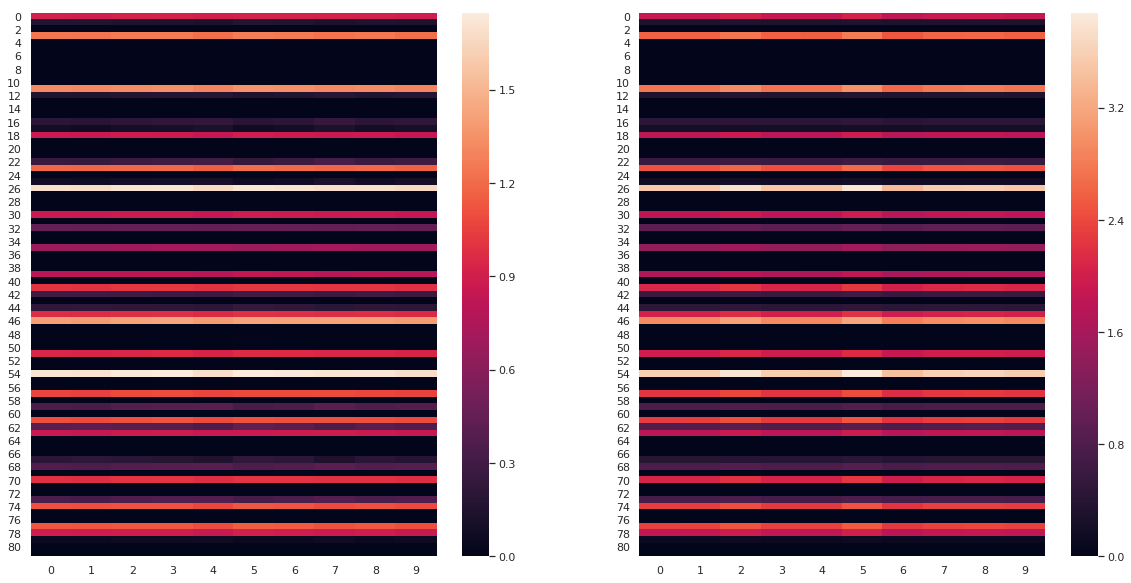

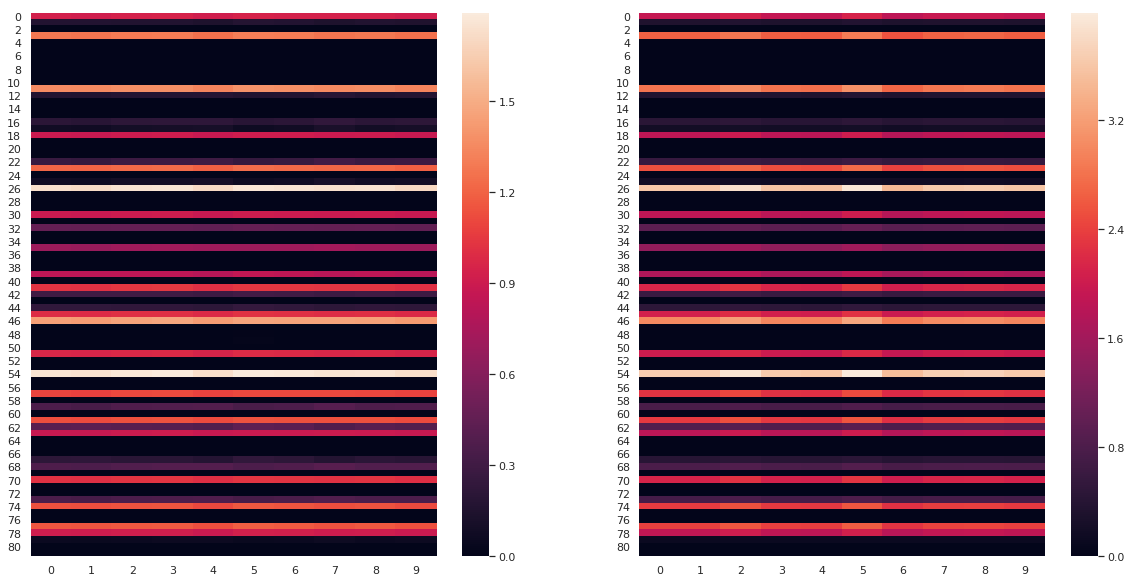

Number of epoch elapsed: 64
Early stopping criterion used: generalization_loss

Final training accuracy: 0.6121951219512195
Final validation accuracy: 0.5

Confusion matrix, without normalization
[[41  0]
 [41  0]]



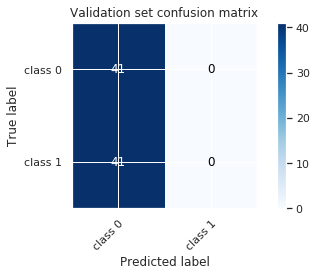

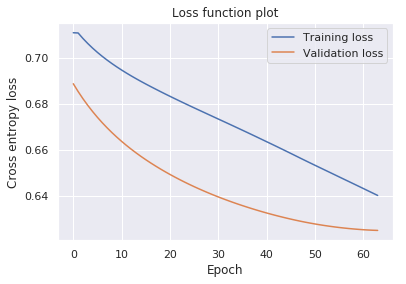

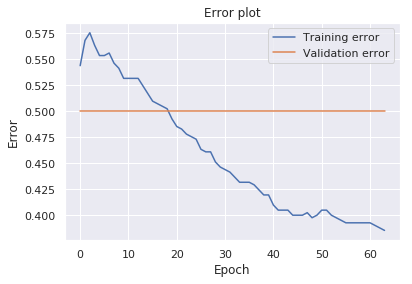

0.5

In [0]:
#h1_weights, h2_weights, out_weights, h1_bias, h2_bias, out_bias=create_weights_and_biases(0.00050)
showActivation(0.1,*create_weights_and_biases(0.00050))

## Best model

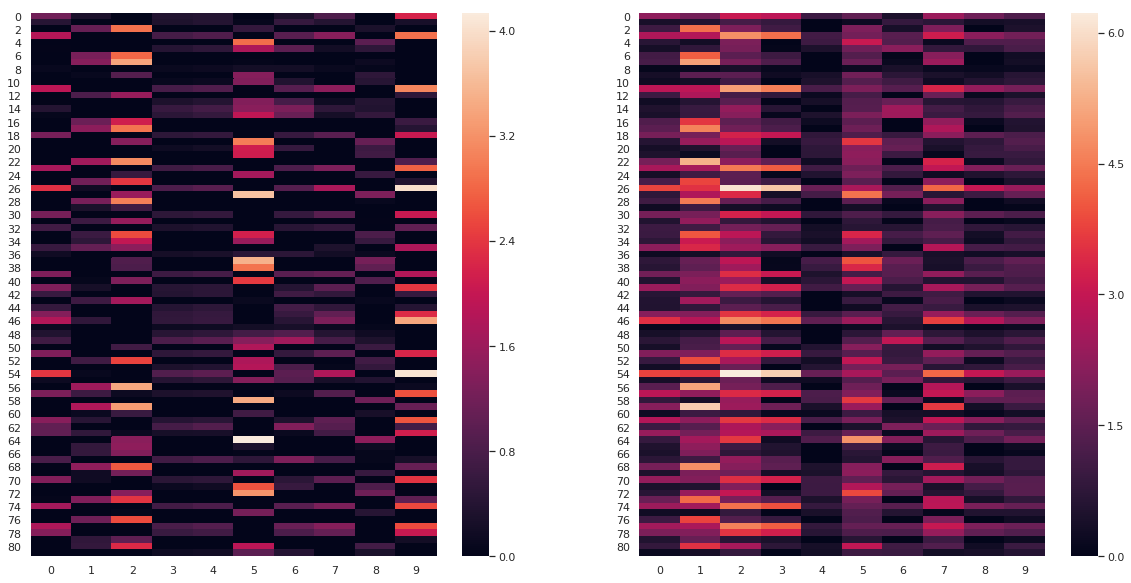

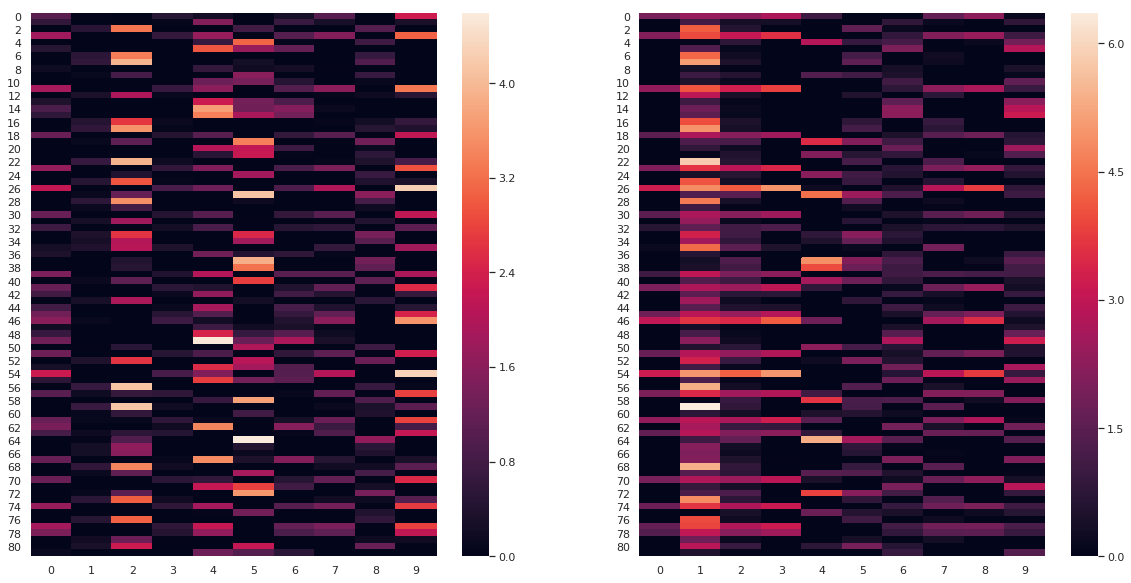

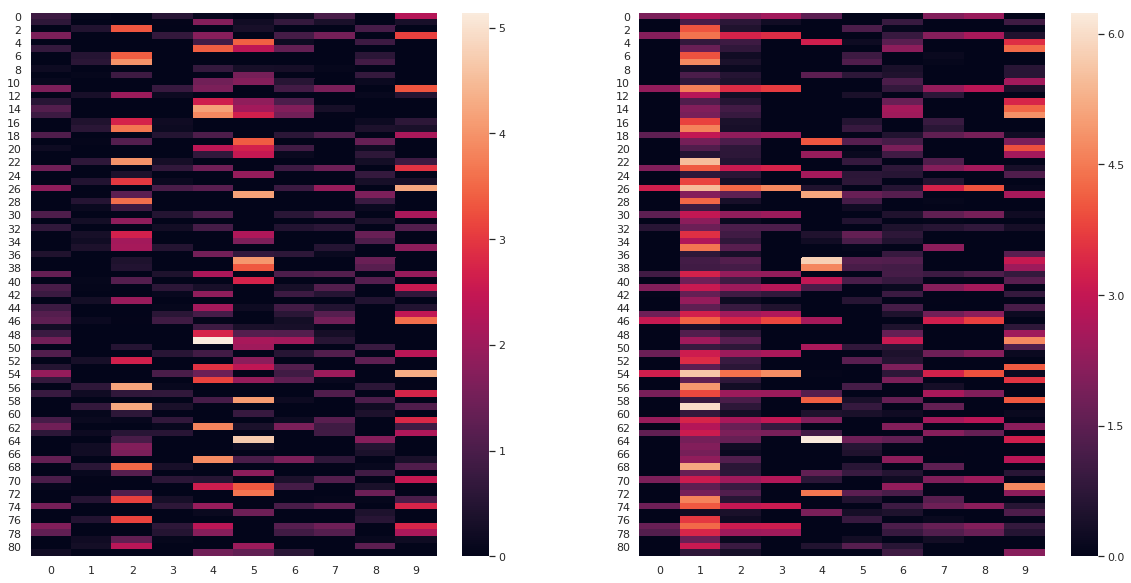

Number of epoch elapsed: 102
Early stopping criterion used: generalization_loss

Final training accuracy: 0.973170731707317
Final validation accuracy: 0.9634146341463414

Confusion matrix, without normalization
[[39  2]
 [ 1 40]]



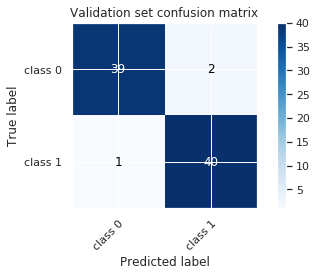

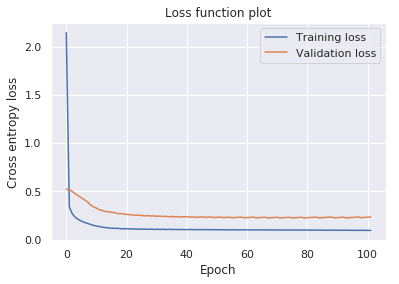

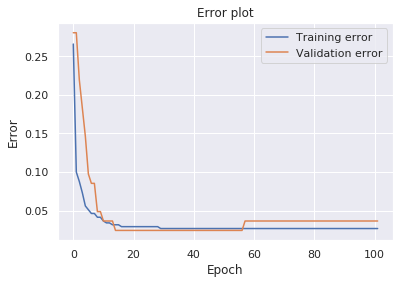

0.9634146341463414

In [0]:
showActivation(0.75,*create_weights_and_biases(1))

## comments :

- worst model have same activation map in starting ,middle and end of the training process
- Best model changes (adjust its weights) during training thats why the Activation map changes in all the three places




## Hyperparameter Optimization

 - learning rate, 
 - number of hidden neurons per layer, 
 - type of activation function
 

In [0]:
def showActivation(alpha,h1_weights, h2_weights, out_weights, h1_bias, h2_bias, out_bias,verbose=True):
  ##############################################################################
  # NN performance statistics
  training_error = []
  validation_error = []

  training_loss = []
  validation_loss = []

  pred = np.zeros(inputs.shape)

  ##############################################################################
  # neural network training
  epoch = 0  
  h1_out = relu(validation_inputs.dot(h1_weights))
  h2_out = relu(h1_out.dot(h2_weights))
  plotActivation(h1_out,h2_out)
  while(epoch < max_epochs):
      epoch += 1
      correct_cnt = 0
      
      for batch in range(num_batches):
          batch_start = batch * batch_size
          batch_end = (batch + 1) * batch_size
          
          # feedforward
          h1_out = leaky_relu(inputs[batch_start:batch_end].dot(h1_weights) + h1_bias)
          h2_out = leaky_relu(h1_out.dot(h2_weights) + h2_bias)
          out = softmax(h2_out.dot(out_weights) + out_bias)
          

          # save outputs
          for i in range(batch_size):
              correct_cnt += int(np.argmax(out[i]) == \
                                np.argmax(labels[batch_start+i]))
          pred[batch_start:batch_end] = out

          # backpropagation
          out_delta = (out - labels[batch_start:batch_end]) / (out.shape[0] * out.shape[1])
          h2_delta = out_delta.dot(out_weights.T) * leaky_relu_deriv(h2_out)
          h1_delta = h2_delta.dot(h2_weights.T) * leaky_relu_deriv(h1_out)

          out_weights -= alpha * h2_out.T.dot(out_delta)
          h2_weights -= alpha * h1_out.T.dot(h2_delta)
          h1_weights -= alpha * inputs[batch_start:batch_end].T.dot(h1_delta)
          
          out_bias -= alpha * np.sum(out_delta, axis=0, keepdims=True)
          h2_bias -= alpha * np.sum(h2_delta, axis=0, keepdims=True)
          h1_bias -= alpha * np.sum(h1_delta, axis=0, keepdims=True)
      
      # training loss and error
      training_error.append(1 - correct_cnt/len(inputs))
      training_loss.append(log_loss(labels, pred))
      
      # validation loss and error
      validation_correct_cnt = 0
      h1_out = relu(validation_inputs.dot(h1_weights))
      h2_out = relu(h1_out.dot(h2_weights))
      out = softmax(h2_out.dot(out_weights))
      if epoch==50:
        plotActivation(h1_out,h2_out)
      for i in range(len(validation_inputs)):
          validation_correct_cnt += int(np.argmax(out[i]) == \
                                        np.argmax(validation_labels[i]))
      validation_pred = out
      
      validation_error.append(1 - validation_correct_cnt/len(validation_inputs))
      validation_loss.append(log_loss(validation_labels, validation_pred))
      
      # check early stopping conditions every N epoch
      if(epoch % ES_N_epoch == 0):
          if((ES_criterion == 'validation_loss')\
            and (validation_loss[-1] > validation_loss[-ES_N_epoch])\
            and (epoch > min_epochs)):
              # stop training
              break
          elif((ES_criterion == 'generalization_loss')\
              and ((validation_loss[-1]/min(validation_loss) - 1) > gen_loss_thold)\
              and (epoch > min_epochs)):
              # stop training
              break

          # progress describes how quickly validation loss changes 
          progress = 1000 * (np.sum(validation_loss[-1:-(ES_N_epoch+1):-1])\
                            / (ES_N_epoch * min(validation_loss[-1:-(ES_N_epoch+1):-1])) - 1)            
          if(progress < validation_progress_thold):
              # stop training
              break
  plotActivation(h1_out,h2_out)
  if verbose:
    ##############################################################################
    # training summary
    print("Number of epoch elapsed:", epoch)
    print("Early stopping criterion used:", ES_criterion)
    print("")

    # pick accuracy from the last successful early stopping check
    print("Final training accuracy:", 1 - training_error[-ES_N_epoch])
    print("Final validation accuracy:", 1 - validation_error[-ES_N_epoch])
    print("")

    #confusion_matrix(validation_y, np.argmax(validation_pred, axis=1), labels=[0, 1])
    np.set_printoptions(precision=2)
    plot_confusion_matrix(validation_y, np.argmax(validation_pred, axis=1), np.array(["class 0", "class 1"]),\
                          title="Validation set confusion matrix")
    print("")

    # loss funtion plot
    fig, ax = plt.subplots()
    training_loss_line, = ax.plot(range(epoch), training_loss)
    validation_loss_line, = ax.plot(range(epoch), validation_loss)
    ax.set(xlabel="Epoch", ylabel="Cross entropy loss", title="Loss function plot")
    plt.legend((training_loss_line, validation_loss_line), ('Training loss', 'Validation loss'))

    # error funtion plot
    fig, ax = plt.subplots()
    training_error_line, = ax.plot(range(epoch), training_error)
    validation_error_line, = ax.plot(range(epoch), validation_error)
    ax.set(xlabel="Epoch", ylabel="Error", title="Error plot")
    plt.legend((training_error_line, validation_error_line), ('Training error', 'Validation error'))
    plt.show()
  return 1 - validation_error[-ES_N_epoch]